In [14]:
# add folders to Python's search space
import os, sys
from pathlib import Path
script_dir = Path(os.path.dirname(os.path.abspath('')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
print(module_dir)

# import the rest of the modules
%matplotlib nbagg
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import arch
import pandas as pd
from scipy.signal import savgol_filter
DTYPE = 'float32'
save_folder = '../data/sphere-geodesic'

class LSTMForgetNet(tf.keras.models.Model):
    """
    Description: 
        LSTM Forget architecture
    Args:
        num_nodes: number of nodes in each LSTM layer
        num_layers: number of LSTM layers
    """
    def __init__(self, num_nodes, num_blocks, dtype=tf.float32, name = 'LSTMForgetNet', dim=1):
        super().__init__(dtype=dtype, name=name)
        self.num_nodes = num_nodes
        self.num_blocks = num_blocks
        self.lstm_blocks = [arch.LSTMForgetBlock(num_nodes, dtype=dtype) for _ in range(num_blocks)]
        self.final_dense = tf.keras.layers.Dense(units=dim, activation=tf.keras.activations.tanh, dtype=dtype)
        self.batch_norm = tf.keras.layers.BatchNormalization(axis=1)
        
        

    def call(self, *args):
        x = tf.concat(args, axis=1)
        h = tf.zeros_like(x)
        c = tf.zeros((x.shape[0], self.num_nodes), dtype=self.dtype)
        for i in range(self.num_blocks):
            h, c = self.lstm_blocks[i](x, h, c)
            # h = self.batch_norm(h)
            # c = self.batch_norm(c)
        y = (self.final_dense(h)+1) * np.pi
        return y
    
class VanillaNet(tf.keras.models.Model):

    def __init__(self, num_nodes, num_layers, dtype=tf.float32, name='VanillaNet', dim=1):
        super().__init__(dtype=dtype, name=name)
        self.num_nodes = num_nodes
        self.num_layers = num_layers 
        if isinstance(num_nodes, list):
            self.dense_layers = [tf.keras.layers.Dense(units=num_nodes[i], activation=tf.keras.activations.tanh) for i in range(num_layers)]
        else:
            self.dense_layers = [tf.keras.layers.Dense(units=num_nodes, activation=tf.keras.activations.tanh) for _ in range(num_layers)]
        self.final_dense = tf.keras.layers.Dense(units=dim, activation=tf.keras.activations.tanh, dtype=dtype)
        self.batch_norms = [tf.keras.layers.BatchNormalization() for _ in range(num_layers)]

    def call(self, *args):
        x = tf.concat(args, axis=1)
        for i in range(self.num_layers):
            x = self.dense_layers[i](x)
            #x = self.batch_norms[i](x)
        y =  (self.final_dense(x)+1) * np.pi
        return y

C:\Users\pinak\Documents\GitHub\var-al


<IPython.core.display.Javascript object>


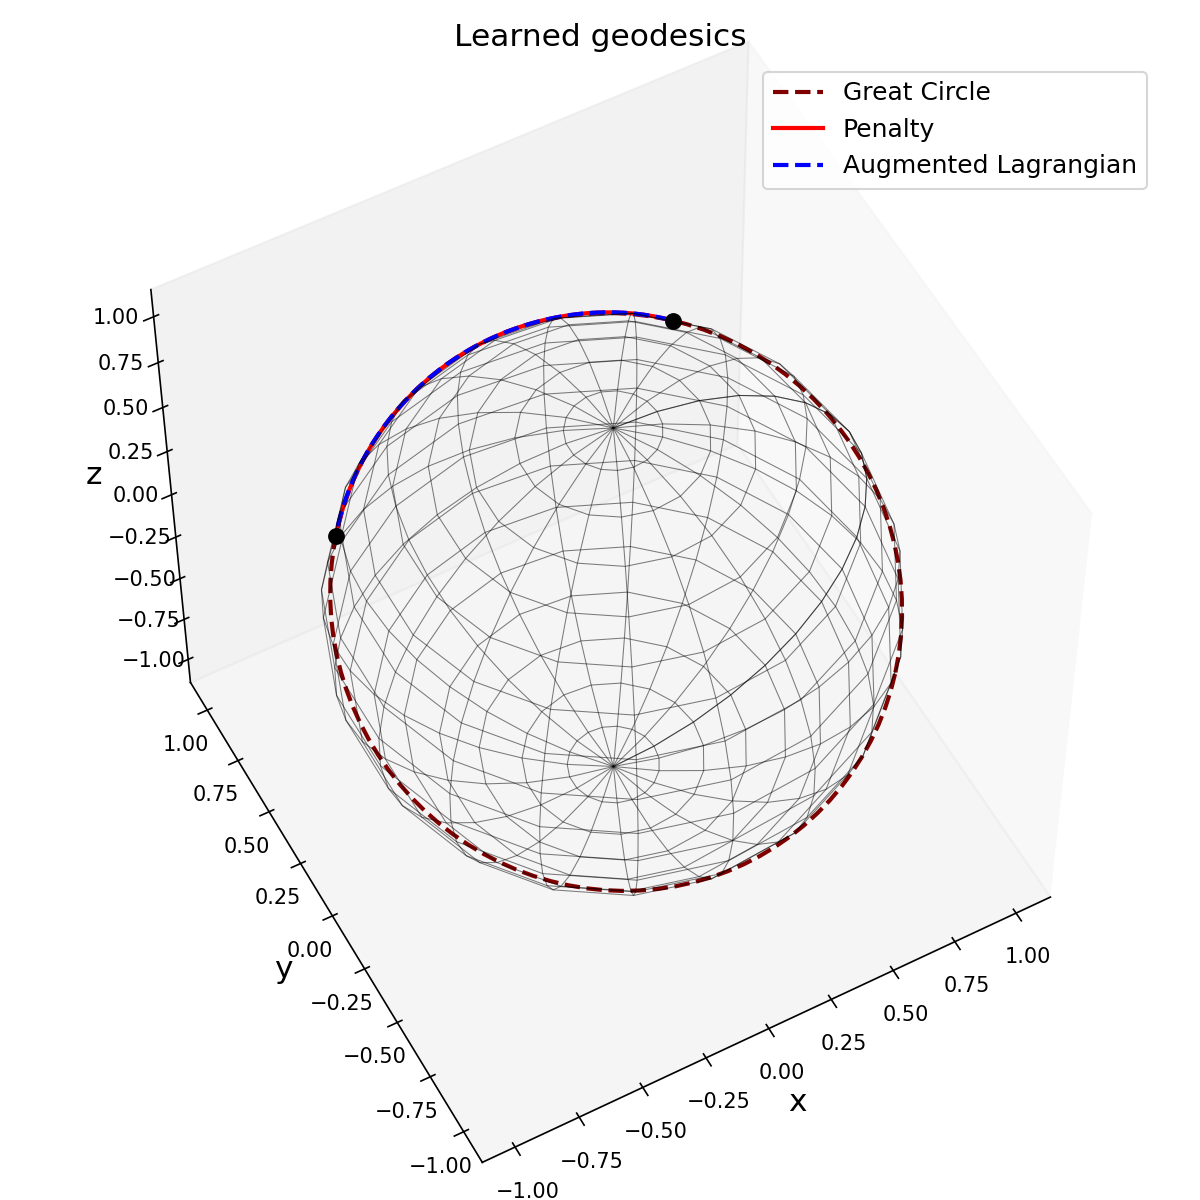

In [58]:
# load learned solutions
net_p = arch.VanillaNet(50, 3, DTYPE, name="sphere-geodesic")
net_p.load_weights('{}/{}'.format(save_folder, net_p.name)).expect_partial()

# net_al = arch.VanillaNet(50, 3, DTYPE, name='helicoid-al')
# net_al.load_weights('../data/helicoid-al/{}'.format(net_al.name)).expect_partial()

# set up plotting parameters
scale = 0
xlabel_size = ylabel_size = 15 + scale
tick_size = 10 + scale
legend_size = 15 + scale
title_size = 15 + scale
cbar_tick_size = 10 + scale
line_color = "darkgrey"

filename='../plots/sphere-geodesic'
resolution=20
# plot solutions

fig = plt.figure(figsize=(8, 8))
ax_p = fig.add_subplot(111, projection='3d')

# plotting params  
ax_p.tick_params(axis='both', which='major', labelsize=tick_size)
ax_p.tick_params(axis='both', which='minor', labelsize=tick_size)
ax_p.set_title('Learned geodesics', fontsize=title_size)
ax_p.set_xlabel('x', fontsize=xlabel_size)
ax_p.set_ylabel('y', fontsize=ylabel_size)
ax_p.set_zlabel('z', fontsize=ylabel_size)
root2 = np.sqrt(2., dtype=DTYPE)
root3 = np.sqrt(3., dtype=DTYPE)


# points =========< start

theta_0, phi_0 = np.pi/4, np.pi/4
X0 = np.array([np.sin(theta_0)*np.cos(phi_0), np.sin(theta_0)*np.sin(phi_0), np.cos(theta_0)], dtype=DTYPE) 

theta_1, phi_1 = np.pi/2., 3.*np.pi/4
X1 = np.array([np.sin(theta_1)*np.cos(phi_1), np.sin(theta_1)*np.sin(phi_1), np.cos(theta_1)], dtype=DTYPE)


X2 = X1 - np.dot(X0, X1)*X0
X2 /= np.sqrt(1. - np.dot(X0, X1)**2)

objective = np.arccos(np.dot(X0, X1))


dtheta = theta_1 - theta_0
tan0, tan1 = np.tan(theta_0), np.tan(theta_1)
sindt, tandt = np.sin(dtheta), np.tan(dtheta)
b = phi_1 + np.arctan(1./tandt - tan1/(tan0 * sindt))
a = 1./(tan1 * np.cos(phi_1 - b))

ax_p.scatter(X0[0], X0[1], X0[2], color='black', s=50)
ax_p.scatter(X1[0], X1[1], X1[2], color='black', s=50)
# points end =========< end


# true great circle ==========< start

def keep_neg(x):
    cond = tf.less(x, tf.zeros(tf.shape(x)))
    out = tf.where(cond, tf.zeros(tf.shape(x)), tf.ones(tf.shape(x)))
    return (1-out).numpy()

def true_phi(t):
    return np.arccos(1./(a * np.tan(t))) + b

def true(t):
    t1 = objective * (t - theta_0) / (theta_1 - theta_0)
    x = np.cos(t1) * X0[0] + np.sin(t1) * X2[0]
    y = np.cos(t1) * X0[1] + np.sin(t1) * X2[1]
    z = np.cos(t1) * X0[2] + np.sin(t1) * X2[2]
    return x, y, z

t = np.linspace(0, np.pi, num=100, endpoint=True).astype(DTYPE)
x, y, z = true(t)
ax_p.plot(x, y, z, color='maroon', linewidth=2., label='Great Circle', linestyle='dashed')

# # true great circle ==========< end

# plot arc
# t = np.linspace(theta_0, theta_1, num=100, endpoint=True).astype(DTYPE)
# phi = true_phi(t)
# ax_p.plot(np.sin(t)*np.cos(phi), np.sin(t)*np.sin(phi), np.cos(t), color='green', linewidth=2., label='Great Arc')



# plot penalty solution
net_p = VanillaNet(50, 10, DTYPE, name="sphere-geodesic")
net_p.load_weights('{}/{}'.format(save_folder, net_p.name)).expect_partial()
t = np.linspace(theta_0, theta_1, num=100, endpoint=True).astype(DTYPE)
phi = net_p(t.reshape(-1, 1)).numpy().flatten()
ax_p.plot(np.sin(t)*np.cos(phi), np.sin(t)*np.sin(phi), np.cos(t), color='red', linewidth=2., label='Penalty')


# plot AL solution
net_al = VanillaNet(50, 10, DTYPE, name="sphere-geodesic")
net_al.load_weights('{}-al/{}'.format(save_folder, net_p.name)).expect_partial()
t = np.linspace(theta_0, theta_1, num=100, endpoint=True).astype(DTYPE)
phi = net_al(t.reshape(-1, 1)).numpy().flatten()
ax_p.plot(np.sin(t)*np.cos(phi), np.sin(t)*np.sin(phi), np.cos(t), color='blue', linewidth=2.,\
          linestyle='dashed', label='Augmented Lagrangian')



# plot sphere
p0 = np.linspace(0., 2.*np.pi, num=resolution, endpoint=True).astype(DTYPE)
t0 = np.linspace(0., np.pi, num=resolution, endpoint=True).astype(DTYPE)
p0, t0 = np.meshgrid(p0, t0)
c, s = np.cos(t0), np.sin(t0)
xs, ys, zs = s*np.cos(p0), s*np.sin(p0), c
ax_p.set_box_aspect((np.ptp(xs), np.ptp(ys), np.ptp(zs))) 
ax_p.plot_wireframe(xs, ys, zs, color='black', alpha=0.5, linewidth=0.5)
ax_p.grid(False)


ax_p.legend(fontsize=legend_size-3)
fig.tight_layout()
plt.savefig('{}.png'.format(filename), dpi=300)
plt.show()

<IPython.core.display.Javascript object>


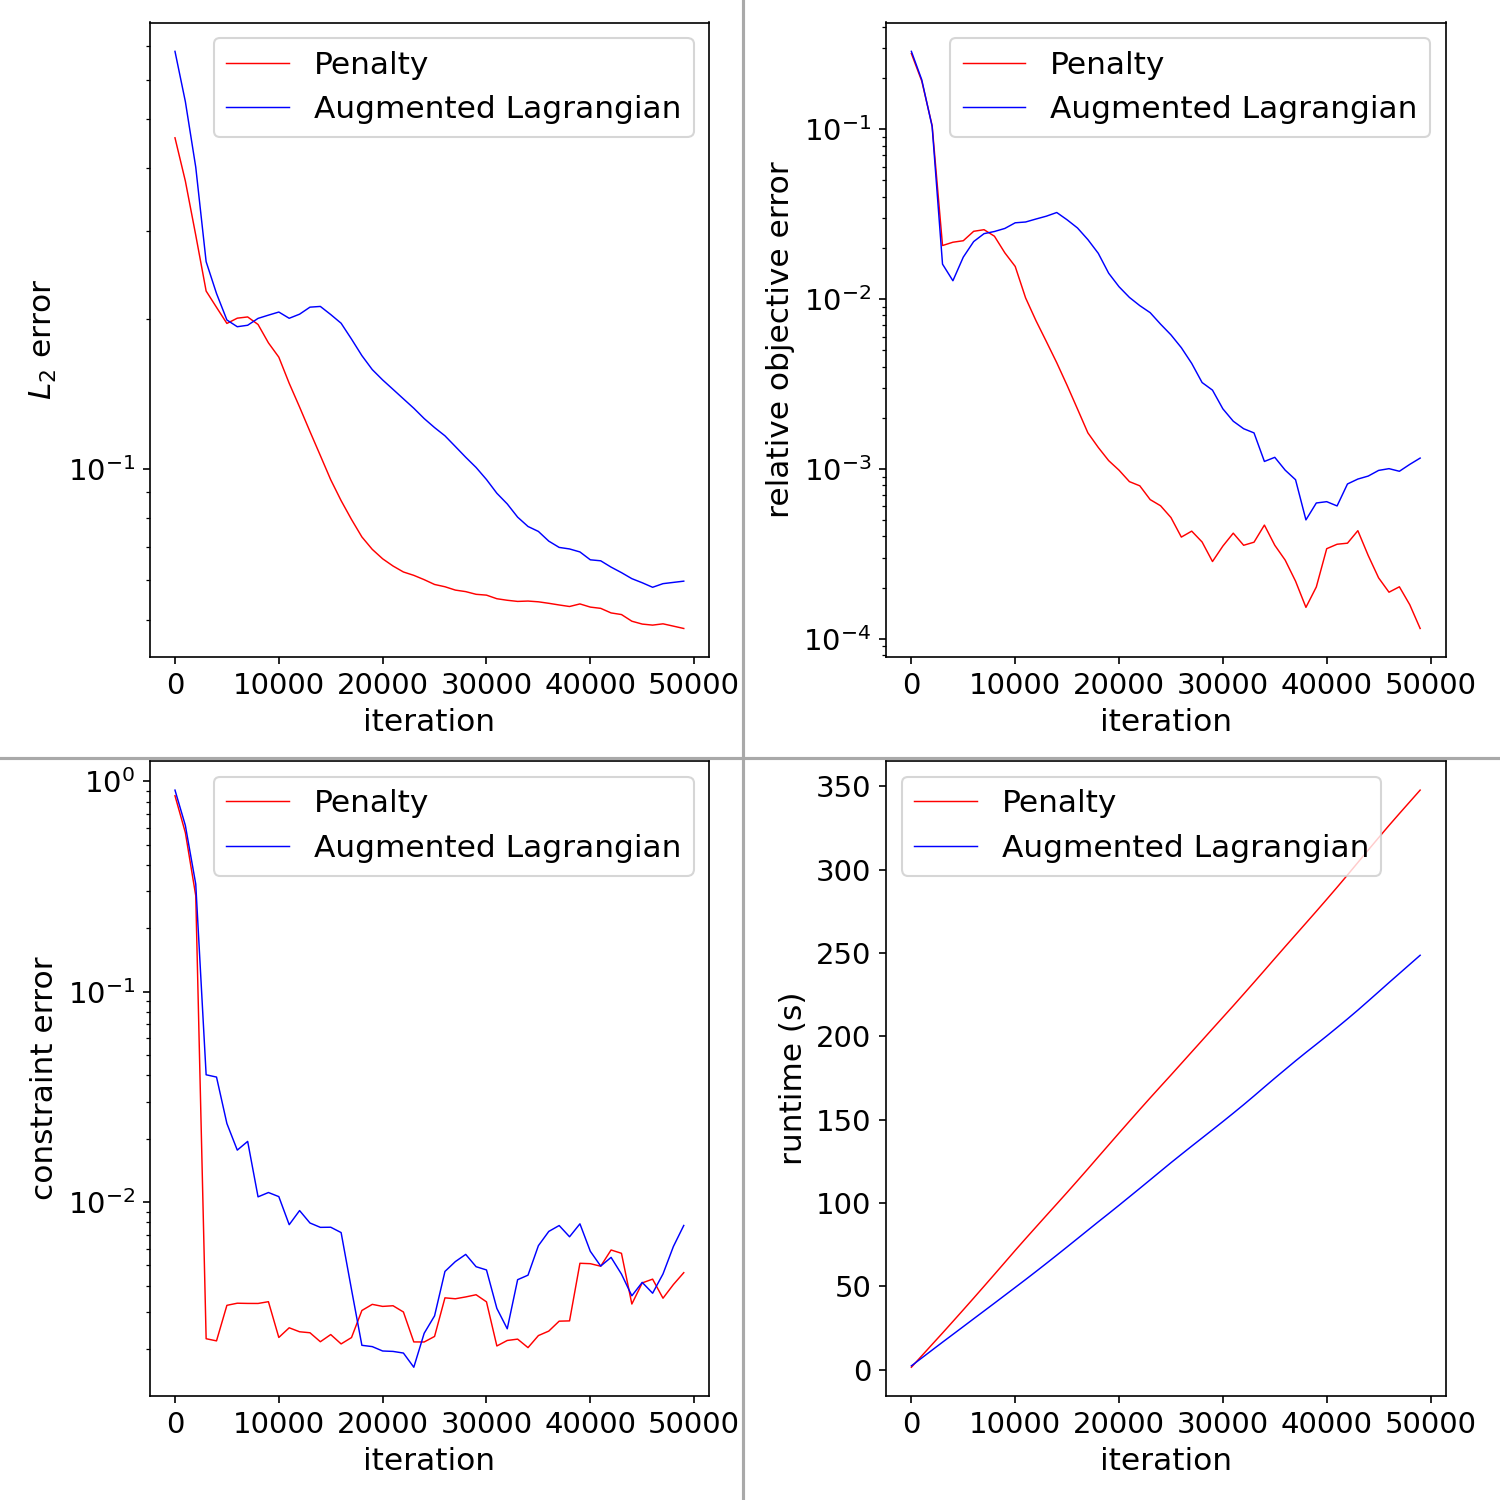

In [54]:
def smooth(y, k):
    y_smooth = savgol_filter(y, 5, k)
    return y_smooth

tick_size = 14 + scale
def plot_errors(filename, last, interval, k):
    fig = plt.figure(figsize=(10, 10))
    ax_l = fig.add_subplot(221)
    ax_o = fig.add_subplot(222)
    ax_c = fig.add_subplot(223)
    ax_m = fig.add_subplot(224)
    # plotting params  
    ax_l.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_l.tick_params(axis='both', which='minor', labelsize=tick_size)
    #ax_l.set_title('Penalty solution', fontsize=title_size)
    ax_l.set_xlabel('iteration', fontsize=xlabel_size)
    ax_l.set_ylabel(r'$L_2$ error', fontsize=ylabel_size)
    
    ax_o.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_o.tick_params(axis='both', which='minor', labelsize=tick_size)
    #ax_o.set_title('Augmented Lagrangian solution', fontsize=title_size)
    ax_o.set_xlabel('iteration', fontsize=xlabel_size)
    ax_o.set_ylabel('relative objective error', fontsize=ylabel_size)

    ax_c.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_c.tick_params(axis='both', which='minor', labelsize=tick_size)
    #ax_c.set_title('True solution', fontsize=title_size)
    ax_c.set_xlabel('iteration', fontsize=xlabel_size)
    ax_c.set_ylabel('constraint error', fontsize=ylabel_size)
    
    ax_m.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_m.tick_params(axis='both', which='minor', labelsize=tick_size)
    #ax_c.set_title('True solution', fontsize=title_size)
    ax_m.set_xlabel('iteration', fontsize=xlabel_size)
    ax_m.set_ylabel('runtime (s)', fontsize=ylabel_size)
    
    df_p = pd.read_csv('../data/sphere-geodesic/train_log.csv')
    df_al = pd.read_csv('../data/sphere-geodesic-al/train_log.csv')

    x = df_p['iteration'].to_numpy()[0:last:interval]
    ax_l.semilogy(x, smooth(df_p['L2-error'].to_numpy()[0:last:interval], k), linewidth=0.7, label='Penalty', c='red')
    ax_l.semilogy(x, smooth(df_al['L2-error'].to_numpy()[0:last:interval], k), linewidth=0.7, label='Augmented Lagrangian', c='blue')
    ax_l.legend(fontsize=legend_size)
    ax_o.semilogy(x, smooth(np.abs(df_p['objective-error'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Penalty', c='red')
    ax_o.semilogy(x, smooth(np.abs(df_al['objective-error'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Augmented Lagrangian', c='blue')
    ax_o.legend(fontsize=legend_size)
    ax_c.semilogy(x, smooth(np.abs(df_p['constraint-error'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Penalty', c='red')
    ax_c.semilogy(x, smooth(np.abs(df_al['constraint-error'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Augmented Lagrangian', c='blue')
    ax_c.legend(fontsize=legend_size)
    ax_m.plot(x, smooth(np.abs(df_p['runtime'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Penalty', c='red')
    ax_m.plot(x, smooth(np.abs(df_al['runtime'].to_numpy()[0:last:interval]), k), linewidth=0.7, label='Augmented Lagrangian', c='blue')
    ax_m.legend(fontsize=legend_size)

    l = 0.45
    line = plt.Line2D([l+.045,l+.045],[0.,1], transform=fig.transFigure, color=line_color)
    fig.add_artist(line)
    l = 0.45
    line = plt.Line2D([0.0,1],[l+.045,l+.045], transform=fig.transFigure, color=line_color)
    fig.add_artist(line)
    fig.tight_layout()
    plt.savefig('{}.png'.format(filename), dpi=300)
    plt.show()
    

plot_errors('../plots/sphere-geodesic-error', last=500, interval=10, k=1)

<IPython.core.display.Javascript object>


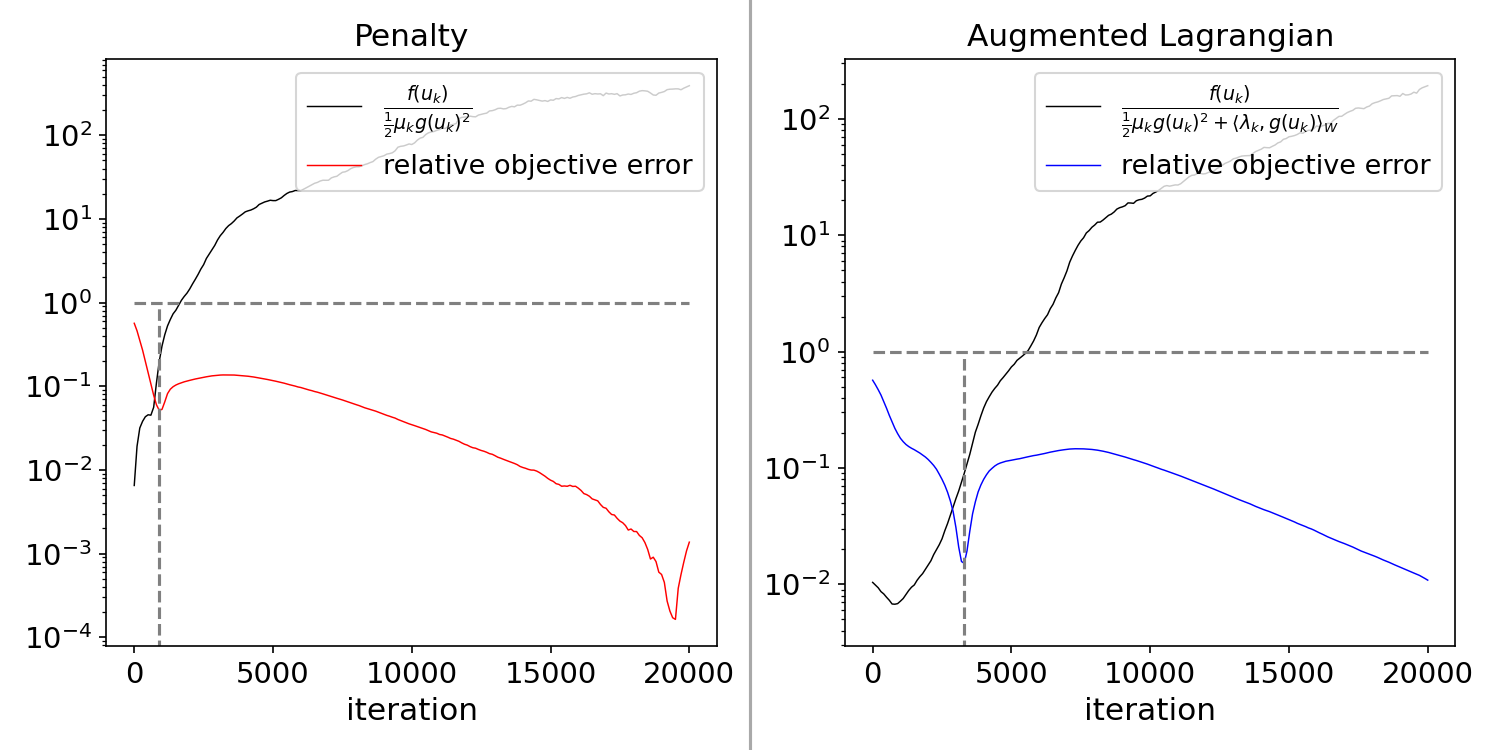

In [60]:
tick_size = 14 + scale
def plot_errors(filename, last, interval, k):
    fig = plt.figure(figsize=(10, 5))
    ax_l = fig.add_subplot(121)
    ax_o = fig.add_subplot(122)

    # plotting params  
    ax_l.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_l.tick_params(axis='both', which='minor', labelsize=tick_size)
    ax_l.set_title('Penalty', fontsize=title_size)
    ax_l.set_xlabel('iteration', fontsize=xlabel_size)
#     ax_l.set_ylabel(r'$L_2$ error', fontsize=ylabel_size)
    
    ax_o.tick_params(axis='both', which='major', labelsize=tick_size)
    ax_o.tick_params(axis='both', which='minor', labelsize=tick_size)
    ax_o.set_title('Augmented Lagrangian', fontsize=title_size)
    ax_o.set_xlabel('iteration', fontsize=xlabel_size)
#     ax_o.set_ylabel('relative objective error', fontsize=ylabel_size)

#     ax_c.tick_params(axis='both', which='major', labelsize=tick_size)
#     ax_c.tick_params(axis='both', which='minor', labelsize=tick_size)
#     #ax_c.set_title('True solution', fontsize=title_size)
#     ax_c.set_xlabel('iteration', fontsize=xlabel_size)
#     ax_c.set_ylabel('constraint error', fontsize=ylabel_size)

#     ax_m.tick_params(axis='both', which='major', labelsize=tick_size)
#     ax_m.tick_params(axis='both', which='minor', labelsize=tick_size)
#     #ax_c.set_title('True solution', fontsize=title_size)
#     ax_m.set_xlabel('iteration', fontsize=xlabel_size)
#     ax_m.set_ylabel('runtime (s)', fontsize=ylabel_size)
    
    df_p = pd.read_csv('../data/helicoid/train_log.csv')
    df_al = pd.read_csv('../data/helicoid-al/train_log.csv')

    x = df_p['iteration'].to_numpy()[0:last:interval]
    loss_a = df_p['loss_a'].to_numpy()[0:last:interval]
    loss_b = df_p['loss_b'].to_numpy()[0:last:interval] * 0.5 * df_p['beta'].to_numpy()[0:last:interval] 
    y = np.abs(df_p['objective-error'].to_numpy()[0:last:interval])
    i = np.argmin(y[:50])
    ax_l.semilogy(x, smooth(loss_a/loss_b, k), linewidth=0.7, label=r'$\frac{{f(u_k)}}{{\frac{1}{2}\mu_kg(u_k)^2}}$', c='black')
    ax_l.semilogy(x, smooth(y, k), linewidth=0.7, label='relative objective error', c='red')
    ax_l.semilogy(x, np.ones_like(x), c='grey', linestyle="dashed")
    ax_l.plot(x[i]*np.ones_like(x), np.linspace(0., 1., num=len(x)), c='grey', linestyle="dashed")
    ax_l.legend(fontsize=legend_size-2, loc='upper right')

    x = df_al['iteration'].to_numpy()[0:last:interval]
    loss_a = df_al['loss_a'].to_numpy()[0:last:interval]
    loss_b = df_al['loss_b'].to_numpy()[0:last:interval] * 0.5 * df_p['beta'].to_numpy()[0:last:interval]\
             + df_al['loss_m'].to_numpy()[0:last:interval]
    y = np.abs(df_al['objective-error'].to_numpy()[0:last:interval])
    i = np.argmin(y[:50])
    ax_o.semilogy(x, smooth(loss_a/loss_b, k), linewidth=0.7, label=r'$\frac{{f(u_k)}}{{\frac{1}{2}\mu_kg(u_k)^2+\langle\lambda_k, g(u_k)\rangle_W}}$', c='black')
    ax_o.semilogy(x, smooth(y, k), linewidth=0.7, label='relative objective error', c='blue')
    ax_o.semilogy(x, np.ones_like(x), c='grey', linestyle="dashed")
    ax_o.plot(x[i]*np.ones_like(x), np.linspace(0., 1., num=len(x)), c='grey', linestyle="dashed")
    ax_o.legend(fontsize=legend_size-2, loc='upper right')
    
    
    l = 0.455
    line = plt.Line2D([l+.045,l+.045],[0.,1], transform=fig.transFigure, color=line_color)
    fig.add_artist(line)
#     l = 0.45
#     line = plt.Line2D([0.0,1],[l+.045,l+.045], transform=fig.transFigure, color=line_color)
#     fig.add_artist(line)
    fig.tight_layout()
    plt.savefig('{}.png'.format(filename), dpi=300)
    plt.show()
    

plot_errors('../plots/helicoid-ratio', last=500, interval=1, k=1)